In [1]:
%%capture
!pip install transformers
!pip install datasets
!pip install transformers[torch]
!pip install accelerate
!pip install huggingface_hub

In [ ]:
from transformers import DistilBertTokenizer, TFDistilBertModel, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, recall_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from datasets import load_dataset
import numpy as np
import torch
from torch.utils.data import DataLoader

dataset = load_dataset("solomonk/reddit_mental_health_posts")

def not_none(example):
    return example['body'] is not None

dataset = dataset.filter(not_none)

dataset_sampled = dataset['train'].train_test_split(test_size=0.7, seed=42)['train']

train_val_test = dataset_sampled.train_test_split(test_size=0.2, seed=42)
train_dataset = train_val_test['train']
test_val_dataset = train_val_test['test']

test_val_split = test_val_dataset.train_test_split(test_size=0.5, seed=42)
validation_dataset = test_val_split['train']
test_dataset = test_val_split['test']

columns_to_keep = ['body', 'subreddit']

columns_to_remove = [col for col in dataset_sampled.column_names if col not in columns_to_keep]

train_dataset = train_dataset.remove_columns(columns_to_remove)
validation_dataset = validation_dataset.remove_columns(columns_to_remove)
test_dataset = test_dataset.remove_columns(columns_to_remove)

le = LabelEncoder()

le.fit(dataset_sampled['subreddit'])

def encode_labels(example):
    example['subreddit'] = le.transform([example['subreddit']])[0]
    return example

train_dataset = train_dataset.map(encode_labels)
validation_dataset = validation_dataset.map(encode_labels)
test_dataset = test_dataset.map(encode_labels)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def prepare_data(example):
    encoding = tokenizer.encode_plus(
        example['body'],
        truncation=True,
        padding='max_length',
        max_length=512,
        return_tensors='pt',
    )
    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(example['subreddit'], dtype=torch.long)
    }

train_dataset = train_dataset.map(prepare_data)
validation_dataset = validation_dataset.map(prepare_data)
test_dataset = test_dataset.map(prepare_data)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
validation_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(le.classes_))

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=validation_dataset,
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
result = trainer.evaluate(test_dataset)

In [8]:
# Extract the predicted labels and true labels
# predictions = torch.argmax(torch.tensor(result.predictions), dim=1).tolist()
test_targets = test_dataset['labels'].numpy()

# Calculate evaluation metrics
accuracy = accuracy_score(test_targets, predictions)
f1 = f1_score(test_targets, predictions, average='macro')
# roc_auc = roc_auc_score(test_targets, result.predictions, multi_class='ovo')
recall = recall_score(test_targets, predictions, average='macro')
precision = precision_score(test_targets, predictions, average='macro')
conf_matrix = confusion_matrix(test_targets, predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")
# print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"Precision (Macro): {precision:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.6709
F1 Score (Macro): 0.6379
Recall (Macro): 0.6137
Precision (Macro): 0.7356
Confusion Matrix:
[[ 899  168   28    9    3]
 [  83 1173   17   20   25]
 [ 168  186  292   16    6]
 [ 138  212   20  316   24]
 [  82  217   26   30  333]]


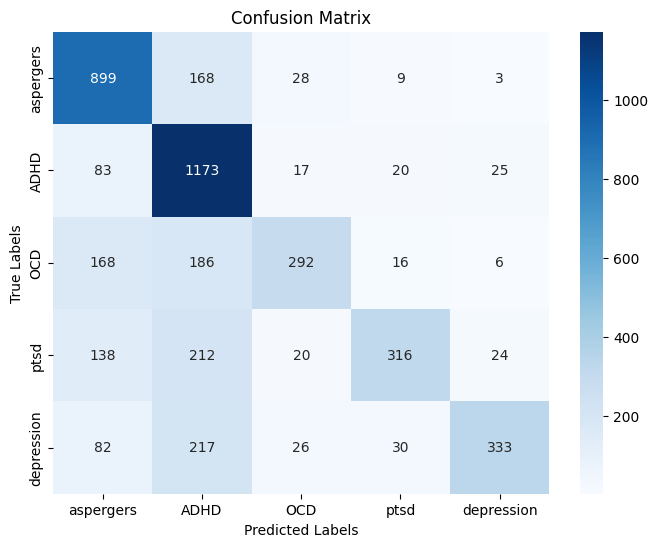

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

candidate_labels = ['aspergers', 'ADHD', 'OCD', 'ptsd', 'depression']
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=candidate_labels, yticklabels=candidate_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()